# Homework 2

This assignment is due Friday, February 24 at 11:59pm Central Time. 

This assignment can be completed in **groups of two**. If you need to find a partner, please post in the pinned note on Piazza.

Once you have formed your groups, the work you submit must belong only to your group members. Do not submit another team's work as your own, and do not allow another team to submit your work as their own. If you use resources you find online, you must cite those in your notebook.

To submit this assignment, you should commit to your GitHub account:

* your Net ID(s) in the netid file; one per line. Please do not put your name in your notebook; we will grade these anonymously.

* a hw2.pdf printout of the completed notebook that shows all your answers.

* your final hw2.ipynb notebook with outputs saved. If we run your notebook from scratch, it should produce an output identical to your PDF. You can edit your notebook however you want (on Colab, on your local machine, somewhere else); just upload the latest version of it to GitHub.

Your GitHub account must submit contain all three of these, or you will lose points. We will not accept late work except in extreme settings.

In [3]:
# If using local runtime
# base_dir = "~/Documents"
# If using hosted runtime
base_dir = "/content"

# helper code from the course repository
!cd $base_dir && git clone -q https://github.com/zachwooddoughty/cs449w23.git
# install common pacakges used for deep learning
!cd $base_dir/cs449w23/ && pip install -q -r requirements.txt

# make sure we're in the right directory
%cd $base_dir/cs449w23/
!git pull -q origin main

fatal: destination path 'cs449w23' already exists and is not an empty directory.
/content/cs449w23


In [4]:
%matplotlib inline

import datetime
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from matplotlib.animation import FuncAnimation
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm

from utils.gan import *

## GANs and Autoencoders

This homework assignment builds off the GAN notebook and the Autoencoder notebook that we saw in class. You may copy any code from those notebooks into your code.

For this assignment, you will combine the models introduced in those two notebooks to create a combined Autoencoder + GAN model. In particular, that will look something like this:

![Diagram of model architecture](https://github.com/zachwooddoughty/cs449w23/raw/main/static/hw2_fig.png)

We're giving you the defined models below and the skeleton of the training code, and you just need to define the optimizers and write the loss functions to allow these models to train together.

If we write this in a functional representation, then the encoder $E(X)$ takes in a real image and outputs a $z$ vector, $G(z)$ takes in a $z$ vecotr and outputs an image $\tilde X$, and $D(X)$ takes in an image and outputs a scalar probability.

The autoencoder loss will be MSELoss comparing $X$ and $\tilde X$ and the generator and discriminator will be otherwise the same as in a GAN. However, the tricky component is to get the model to train and reduce all three losses simultaneously.

In [5]:
class MLPGenerator(torch.nn.Module):
    
    def __init__(self, 
                 number_of_hidden_layers: int, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP generator"""
        
        super().__init__()
        
        assert number_of_hidden_layers >= 0, "Generator number_of_hidden_layers must be at least 0"
        
        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [output_size] # final output should be the size of a true example
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))
            
            if i < number_of_hidden_layers:
                layers.append(activation)
        
        # apply Sigmoid after final layer to constrain generated images to [0, 1]
        layers.append(torch.nn.Sigmoid())
        
        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor):
        return self.net(x)

class MLPDiscriminator(torch.nn.Module):
    
    def __init__(self, 
                 number_of_hidden_layers: int, 
                 input_size: int, 
                 hidden_size: int, 
                 activation: torch.nn.Module):
        """Construct a simple MLP discriminator"""
        
        super().__init__()
        
        msg = "Discriminator number_of_hidden_layers must be at least 0"
        assert number_of_hidden_layers >= 0, msg
        
        # final output dimension is scalar (probability image is real)
        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [1]
        
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))
            
            if i < number_of_hidden_layers:
                layers.append(activation)
        
        # apply sigmoid after final layer to represent probability
        layers.append(torch.nn.Sigmoid())
        
        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor):
        return self.net(x)

class MLPEncoder(torch.nn.Module):
    
    def __init__(self, 
                 number_of_hidden_layers: int, 
                 input_size: int, 
                 hidden_size: int, 
                 latent_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP encoder"""
        
        super().__init__()
        
        assert number_of_hidden_layers >= 0, "Encoder number_of_hidden_layers must be at least 0"
        
        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [latent_size]  # final output should be latent size
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))
            
            if i < number_of_hidden_layers:
                layers.append(activation)

        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor):
        return self.net(x)


class Model(torch.nn.Module):
    def __init__(self,
                 number_of_hidden_layers: int, 
                 latent_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 activation_generator: torch.nn.Module = torch.nn.ReLU(),
                 activation_discriminator: torch.nn.Module = torch.nn.LeakyReLU(0.2)
                ):
        
        super().__init__()

        self.encoder = MLPEncoder(
            number_of_hidden_layers=number_of_hidden_layers, 
            input_size=output_size, 
            hidden_size=hidden_size, 
            latent_size=latent_size,
            activation=activation_generator,
        )
                          
        self.generator = MLPGenerator(
            number_of_hidden_layers=number_of_hidden_layers, 
            input_size=latent_size, 
            hidden_size=hidden_size, 
            output_size=output_size,
            activation=activation_generator
        )
        
        self.discriminator = MLPDiscriminator(
            number_of_hidden_layers=number_of_hidden_layers, 
            input_size=output_size, 
            hidden_size=hidden_size,
            activation=activation_discriminator
        )   

In [6]:
# training hyperparameters
image_size = 28
batch_size = 64
latent_size = 64
hidden_size = 256
number_of_hidden_layers = 2
lr = 0.0002

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load MNIST dataset
mnist = load_mnist(batch_size=batch_size)

# initialize the model
model = Model(
    number_of_hidden_layers=number_of_hidden_layers, 
    latent_size=latent_size, 
    hidden_size=hidden_size, 
    output_size=image_size*image_size, 
).to(device)

# discriminator loss function: binary cross-entropy loss
discrim_loss_func = torch.nn.BCELoss()
# autoencoder loss function: mean squared error between original and new image
autoencoder_loss_func = torch.nn.MSELoss()

# determine which labels will correspond to "real" and "fake" predictions from the discriminator
label_real = 1.0
label_fake = 0.0

# select a fixed set of latent vectors z that we will use to visualize the GAN's generation quality each epoch
fixed_latents = torch.randn((batch_size, latent_size)).to(device)

# use an optimizer to handle parameter updates
opt_discriminator = torch.optim.Adam(model.discriminator.parameters(), lr=lr)
opt_generator = torch.optim.Adam(model.generator.parameters(), lr=lr)
#params = list(model.generator.parameters()) + list(model.encoder.parameters())
#opt_enconder = torch.optim.Adam([{'params': model.generator.parameters()},{'params': model.encoder.parameters()}], lr=lr)
opt_enconder = torch.optim.Adam(model.encoder.parameters(), lr=lr)
#print([{'params': model.generator.parameters()},{'params': model.encoder.parameters()}])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Coding (7 points)

To get this code to run, you need to do two things.

* First, instantiate the optimizer(s) you will use to update your model parameters. Remember that you will need to update parameters in `model.encoder`, `model.generator`, and `model.discriminator`. One decision you have to make is how many optimizers you want to use.

* Write the training code below to compute the loss terms for each part of your model: `loss_discriminator`, `loss_generator`, and `loss_autoencoder`. As in the VAE notebook, you may want to consider weighting these losses differently.

For full points, we must be able to run your notebook as is and reproduce (almost) exactly the same results.

In [7]:
# fix random seed
torch.manual_seed(0)

epochs = 80

# log metrics
loss_d = np.zeros(epochs)
loss_g = np.zeros(epochs)
loss_ae = np.zeros(epochs)

for epoch in range(epochs):
    total_epoch_size = 0

    # Zero out grads at beginning of epoch
    model.encoder.zero_grad()
    model.discriminator.zero_grad()
    model.generator.zero_grad()

    for batch_idx, batch_data in enumerate(mnist):

        x_real, y_real = batch_data
        
        # flatten input images and move to device
        x_real = x_real.to(device)
        n_batch = x_real.shape[0]
        x_real = x_real.reshape(n_batch, -1)



        # TODO: write your training code here to compute loss functions

         ########################################################################
        # STEP 1: train the discriminator network to maximize the objective
        #         log(D(x)) + log(1 - D(G(z)))
        ########################################################################
        
        model.discriminator.zero_grad()
        
        # train on a batch of real inputs
        y_real = torch.full((n_batch, 1), label_real, device=device)
        preds_real = model.discriminator(x_real)
        loss_real = discrim_loss_func(preds_real, y_real)
        
        # train on a batch of synthesized inputs
        z = torch.randn(n_batch, latent_size).to(device)
        x_fake = model.generator(z)
        y_fake = torch.full((n_batch, 1), label_fake, device=device)
        preds_fake = model.discriminator(x_fake.detach())  # exclude generator from gradient computation
        loss_fake = discrim_loss_func(preds_fake, y_fake)
        
        # update discriminator weights
        loss_discriminator = loss_real + loss_fake
        loss_discriminator.backward()
        opt_discriminator.step()
        
        ########################################################################
        # STEP 2: train the generator network to minimize the objective 
        #         log(1 - D(G(z))), or equivalently, to maximize D(G(z))
        ########################################################################
        
        model.generator.zero_grad()
        
        # train on a batch of synthesized inputs
        z = torch.randn(n_batch, latent_size).to(device)
        x_fake = model.generator(z)
        preds_fake = model.discriminator(x_fake)
        x_reconstructed = model.generator(model.encoder(x_real))
        loss_generator = 0.9*discrim_loss_func(preds_fake, y_real) + autoencoder_loss_func(x_real,x_reconstructed)
        loss_generator.backward()
        
        # update generator weights
        opt_generator.step()

        ########################################################################
        # STEP 3: train the encoder network to minimize 
        # the mean-squared error between original and reconstructed images (MSELoss)
        ########################################################################
        model.encoder.zero_grad()
        
        # train on a batch of inputs
        x_reconstructed = model.generator(model.encoder(x_real))#do we need to run this again?
        loss_batch = autoencoder_loss_func(x_real, x_reconstructed)
        loss_batch.backward()
        opt_enconder.step()
        


        # for each model section
        loss_discriminator = loss_discriminator
        loss_generator = loss_generator
        loss_autoencoder = loss_batch
        
        # log losses and scores
        loss_d[epoch] += loss_discriminator.detach().item() * n_batch
        loss_g[epoch] += loss_generator.detach().item() * n_batch
        loss_ae[epoch] += loss_autoencoder.detach().item() * n_batch
        total_epoch_size += n_batch
    

    loss_d[epoch] /= total_epoch_size
    loss_g[epoch] /= total_epoch_size
    loss_ae[epoch] /= total_epoch_size

    if epoch == 0 or (epoch + 1) % max(1, epochs // 10) == 0:
        total = loss_ae[epoch] + loss_g[epoch] + loss_d[epoch]
        log = "  ".join([
            f"Epoch: {epoch + 1:4d}",
            f"AE Loss: {loss_ae[epoch]:0.4f}",
            f"Gen Loss: {loss_g[epoch]:0.4f}",
            f"Dis Loss: {loss_d[epoch]:0.4f}",
            f"Total: {total:0.4f}",
        ])
        print(log)

Epoch:    1  AE Loss: 0.1375  Gen Loss: 4.5621  Dis Loss: 0.1602  Total: 4.8598
Epoch:    8  AE Loss: 0.0695  Gen Loss: 8.5630  Dis Loss: 0.0216  Total: 8.6540
Epoch:   16  AE Loss: 0.0537  Gen Loss: 6.3308  Dis Loss: 0.0868  Total: 6.4713
Epoch:   24  AE Loss: 0.0400  Gen Loss: 3.8611  Dis Loss: 0.2562  Total: 4.1573
Epoch:   32  AE Loss: 0.0297  Gen Loss: 2.2509  Dis Loss: 0.6037  Total: 2.8842
Epoch:   40  AE Loss: 0.0247  Gen Loss: 1.8349  Dis Loss: 0.6992  Total: 2.5588
Epoch:   48  AE Loss: 0.0223  Gen Loss: 1.7131  Dis Loss: 0.7249  Total: 2.4602
Epoch:   56  AE Loss: 0.0207  Gen Loss: 1.6406  Dis Loss: 0.7727  Total: 2.4340
Epoch:   64  AE Loss: 0.0198  Gen Loss: 1.6111  Dis Loss: 0.8064  Total: 2.4374
Epoch:   72  AE Loss: 0.0182  Gen Loss: 1.5632  Dis Loss: 0.7850  Total: 2.3664
Epoch:   80  AE Loss: 0.0171  Gen Loss: 1.5771  Dis Loss: 0.7818  Total: 2.3760


Once you've trained your model, use the next two cells to sample some images from your generator.

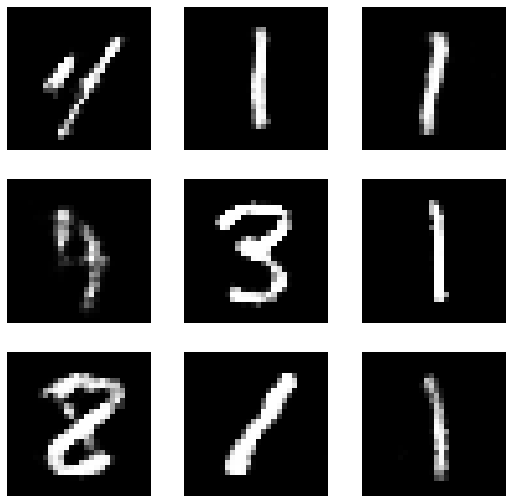

In [10]:
nrows, ncols = (3, 3)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * nrows, 3 * ncols))

for row in range(nrows):
    for col in range(ncols):
        z = torch.randn(1, latent_size).to(device)
        output = model.generator(z).reshape(image_size, image_size).detach().cpu()
        axes[row, col].imshow(output.squeeze(), cmap='gray')
        axes[row, col].axis('off')

plt.show()

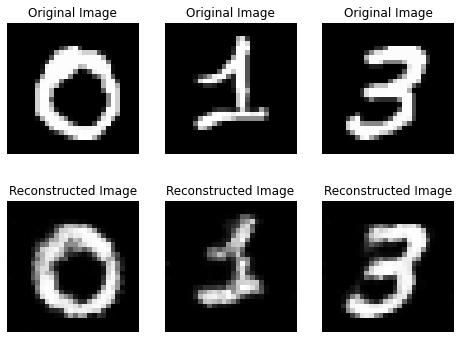

In [11]:
example_batch = next(iter(mnist))[0].to(device)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))

indices = np.argsort(np.random.rand(example_batch.shape[0]))[:3]

for col, index in enumerate(indices):

    example_image = example_batch[index].cpu()
    axes[0, col].imshow(example_image.squeeze(), cmap='gray')
    axes[0, col].set_title("Original Image")
    axes[0, col].axis('off')

    image_input = example_image.flatten().unsqueeze(0).to(device)
    recons_img = model.generator(model.encoder(image_input))
    recons_img = recons_img.reshape(1, image_size, image_size).detach().cpu()
    axes[1, col].imshow(recons_img.squeeze(), cmap='gray')
    axes[1, col].set_title("Reconstructed Image")
    axes[1, col].axis('off')

plt.show()

## Coding explanation (6 points)

### 1. What did you do? (4 points)

Describe your approach in your code above; what choices did you make and why?

If you weren't able to get the model to train, you can still earn these points by describing what you tried and what didn't seem to work.

### 2. Discuss your results (2 points)

If you were able to get your model to train, what did you notice about the trends in the three different loss values? How do your generated images in the previous cells look similar to or different from the images we saw in the GAN or Autoencoder notebooks?

## Answers

###1
In our point of view, the tandem of encoder and generator is like an autoencoder model with generator behaving like a decoder. Under this situation, I can train the sub-model as the way I train an autoencoder to reconstruct an image using MSE loss. Meanthile, it is still a GAN model. With the adversarial risk that is needed to be minimax, max the D term and minimize G term.

We use binary cross-entropy loss to train discriminator and MSE for encoder. And that's what we learned from the lecture. We use both loses to train the generator. Because we want the generator to be able to work kind of like a decoder to generate similar image to the original one in the mean time the image generated by it should be able to fool the discriminator as real ones as well.

As for the optimizer, we defined three seperate optimizers for the three parts' parameters. We believe in this way it's clear which part of the model we are training in regard to specific loss function.

###2
The loss for encoder keeps going down. The trade off between the loss of generator and discriminator are shown. While the loss of discriminator goes down at first, the loss of the generator goes up. And then as the loss of generator goes down, the loss of the discriminator goes up. But the three of them all steadied at the end of the training.

We think the reconstructed images of our model are good enough and similar to that of the two models.

## Conceptual questions (7 points)

### 1. Mode collapse (2 points)

Look back at the slides, notebook, and/or readings around mode collapse in GANs.
* First, give a one or two sentence definition of what mode collapse is, in your own words.
* Second, explain why mode collapse is *more* or *less* likely in the above model that incorporates an autoencoder into the GAN. Write at least two sentences.

### 2. Loss functions (3 points)

In the above model that you trained, there are different loss functions for the autoencoder, generator, and discriminator. For each pair of losses, describe whether and how the two losses are in conflict. That is, when training your model, does reducing loss #1 tend to increase loss #2? Why or why not?

* a. Generator loss and discriminator loss
* b. Generator loss and autoencoder loss
* c. Discriminator loss and autoencoder loss

### 3. Class conditioning (2 points)

Suppose you wanted to add in class-conditioning to [the generator and discriminator](https://arxiv.org/pdf/1411.1784.pdf) and [the autoencoder](https://proceedings.neurips.cc/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf) in your model. How and why would this change your loss function(s)?

## Answers

### 1. Mode collapse

* From our perspective, mode collapse is to describe the situation that the GANs output space is not large enough to cover the real sample space of the targets like images. They can only produce some particular kinds of results or output the same thing repeatedly. It's like two boys playing plasticine. One of them(Mode collapse) can only mode apples no matter what kind of materials he receives. The other guy can mold all kinds of stuff if the materials are enough.

* Without autoencoder, the input of GANs are just random noise. However, with the encoder, the compress progress try hard to keep the important information despite the dimsension is decreased. It's like an input conditional on the real data. The increment of the information can help to produce a wider range of outputs. The encoder also helps ensure that the generator produces outputs that are similar to the target image, rather than just random noise.

* And we can think of an example that the generator find out outputing 6 will always fool the discriminator then no matter what random input we feed the generator, it will only give out 6. However if we add the encoder to the model, the loss for encoder will make the generater to output image similar to the original one, which prevent this problem.

### 2. Loss functions
a. Generator loss and discriminator loss It's the same loss as provided in former notebooks. Reducing generator loss will lead to the increase in the discriminator loss. Intuitively, to cheat the discriminator, the generator should be good enough. Thereafter, after many training epoches, the generator is good enough, and the loss is relatively low, it has ability to cheat discrimnator, this will lead to the increase in the loss of discriminator.

b. Generator loss and autoencoder loss Reducing the generator loss will also reduce the autoencoder loss. The combination of encoder and the generator is like an autoencoder model. When they can provide robust model to make good prediction, the loss of autoencoder loss is low and the generator is more possible to cheat the discriminator. Hence, they have similar variantion tendency.

c. Discriminator loss and autoencoder loss These two losses lso conflict. Autoencoder is to reconstruct verisimilar images. The discriminator is to find it is still not real. The aim is opposite.

### 3. Class conditioning
$h$: the correct label

$\hat{h}$: random wrong labels

$x$: real image

$z = N(0,1)^Z$

$\hat{x} = model.generator(z,h) = G(z,h)$

$\tilde{x} = model.generator(model.encoder(x,h)) = G(E(x,h))$

$s_r = model.discriminator(x,h) = D(x,h)$

$s_w = D(x,\hat{h})$

$s_f = D(\hat{x},h)$

$L_D = log(s_r) + (log(1-s_w) + log(1-s_f))/2$

$L_G = log(s_f) + \alpha * MSE(x,\tilde{x})$, $\alpha$ is the waighting variable

$L_E = MSE(x,\tilde{x})$

I add a loss function addressing mismatching data and label for the discriminator so it can tell if we are generating a image under the correct label or not.

For the loss function of generator and autoencoder, I didn't change them. Because the goal is still to generate a image that will be counted as real by the descriminato and to be able to generate an image that is close to the original one. Though I do include label in the encoding process and the generating process.